# Gamma ray spectroscopy

## Functions

In [11]:
# %load ../setup.py
"""
Packages for plotting and other stuff
version: 1.0
author: Riasat
"""
# %matplotlib widget

# data loading
import pandas as pd

# data maipulation
import pwlf
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.signal import find_peaks

# plotting tools
import matplotlib.pyplot as plt

# extra tweaks
import warnings

warnings.filterwarnings("ignore")

# plot tweaks
plt.style.use("seaborn-poster")
pd.options.display.max_columns = None
pd.options.display.float_format = "{:.5f}".format

# function for extrapolation
def extrapolate1d(x, y):
    f = interp1d(x, y, kind="linear", fill_value="extrapolate")
    a = np.arange(0, x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate1d(x, y):
    f = interp1d(x, y, kind="linear", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate2d(x, y):
    f = interp1d(x, y, kind="quadratic", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate3d(x, y):
    f = interp1d(x, y, kind="cubic", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# funciton for polynomial fitting
def polfit(a, b, c):
    z = np.polyfit(a, b, c)
    f = np.poly1d(z)

    x = np.arange(a[0], a[len(a) - 1], 0.001)
    y = f(x)
    return x, y


# function for picewise linear fit
def picewise_linear_fit(x, y, segments):
    my_pwlf = pwlf.PiecewiseLinFit(x, y)  # fit my data
    res = my_pwlf.fit(segments)  # fit the data for n line segments
    # slopes = myPWLF.calc_slopes()  # calculate slopes

    # predict for the determined points
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = my_pwlf.predict(xHat)

    # calculate statistics
    # p = myPWLF.p_values(method="non-linear", step_size=1e-4)  # p-values
    # se = myPWLF.se  # standard errors
    return xHat, yHat


## Data

In [12]:
file_name = "data_gamma_spec.xlsx"
bg_count = 42

# calibration data
data_cesium_calib = pd.read_excel(file_name, sheet_name="cs calibration")
cs_channel_og = data_cesium_calib["cs_channel"]
cs_counts_og = data_cesium_calib["cs_counts"]
data_cobalt_calib = pd.read_excel(file_name, sheet_name="co calibration")
co_channel_og = data_cobalt_calib["co_channel"]
co_counts_og = data_cobalt_calib["co_counts"]
# distance data
data_dist = pd.read_excel(file_name, sheet_name="distance")
distance_og = data_dist["distance"]
dist_counts_og = data_dist["counts"]
net_dist_counts_og = dist_counts_og - bg_count
data_dist["net counts pm"] = net_dist_counts_og
print(f"{data_cesium_calib}, \n{data_cobalt_calib}, \n{data_dist}")

    cs_channel  cs_counts
0      5.00000       8512
1      6.00000       8952
2      7.00000       9812
3      8.00000      12027
4      9.00000      11115
5     10.00000       9377
6     11.00000       7925
7     12.00000       7210
8     14.00000       6104
9     15.00000       5885
10    16.00000       5894
11    17.00000       5848
12    18.00000       5462
13    19.00000       4688
14    20.00000       2737
15    21.00000       1831
16    22.00000       1201
17    23.00000       1101
18    24.00000       1360
19    25.00000       2974
20    26.00000       8208
21    26.20000       9083
22    26.40000      11059
23    26.60000      12327
24    26.80000      13203
25    27.00000      13885
26    27.20000      14113
27    27.40000      14106
28    27.60000      13374
29    27.80000      12504
30    28.00000      11745
31    28.20000      10116
32    28.40000       8893
33    28.60000       7113
34    28.80000       5914
35    29.00000       4769
36    30.00000       1307
37    31.000

## Spectrum

In [13]:
# cesium 
channel_interpolated_cs, counts_interpolated_cs = interpolate3d(cs_channel_og, cs_counts_og)
# cobalt
channel_interpolated_co, counts_interpolated_co = interpolate3d(co_channel_og, co_counts_og)
# naming the elements
element_name = ["Cesium-137", "Cobalt-60", "Cobalt-60 Lower", "Cobalt-60 Higher"]
channel_interpolated = [channel_interpolated_cs, channel_interpolated_co]
counts_interpolated = [counts_interpolated_cs, counts_interpolated_co]
channel_original = [cs_channel_og, co_channel_og]
counts_original = [cs_counts_og, co_counts_og]


### Peak determination


In [14]:
res_name = ["Cesium-137", "Cobalt-60 lower peak", "Cobalt-60 upper peak"]

for i in range(2):
    peak_id_max = find_peaks(counts_interpolated[i], height=np.max(counts_interpolated[i]) - 500)
    heights = peak_id_max[1]["peak_heights"]
    pos = channel_interpolated[i][peak_id_max[0]]
    print(f"{element_name[i]}: \n\t channel = {pos} and peak = {heights}")


peak_counts = [14173.38421456, 1567.36215049, 1344.06124333]
peak_channel = [27.2, 48, 54]
known_energy = [0.662, 1.171, 1.332]

Cesium-137: 
	 channel = [27.315] and peak = [14173.38421456]
Cobalt-60: 
	 channel = [47.835 53.704] and peak = [1567.38499347 1445.49952008]


### Cesium spectrum

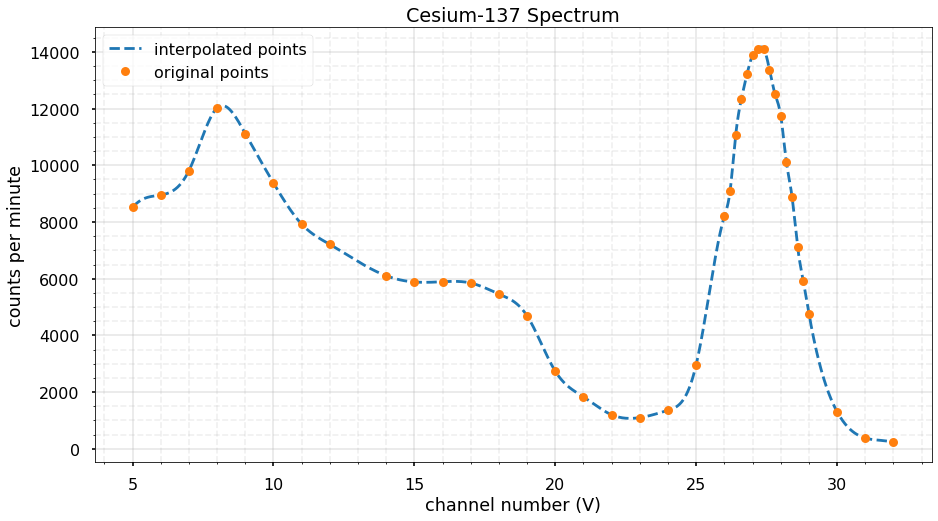

In [15]:
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))

# plt.axvspan(vi[6], vi[7], alpha=0.2)
# for i in range(6, 8):
#     plt.annotate(f"{vi[i]:.2f}", xy=(vi[i]-0.5, 0), fontsize=14)
# plt.annotate(f"43029", xy=(24 + 0.5, 43029), fontsize=14)

plt.title(f"{element_name[0]} Spectrum")
plt.xlabel("channel number (V)")
plt.ylabel("counts per minute")
plt.plot(channel_interpolated_cs, counts_interpolated_cs, "--", label="interpolated points")
plt.plot(cs_channel_og, cs_counts_og, "o", markersize=9, label="original points")
plt.legend(loc="upper left")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")


### Cobalt-60 Spectrum

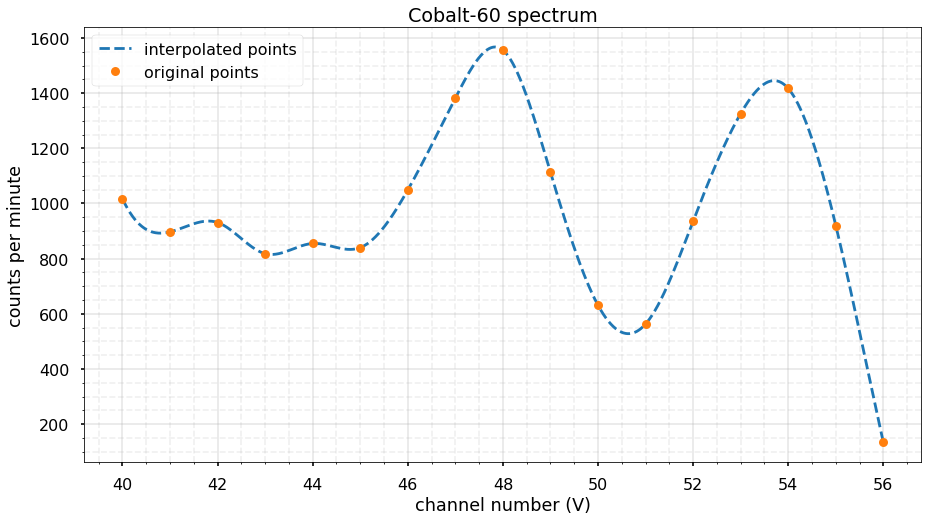

In [16]:
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))

# plt.axvspan(vi[2], vi[3], alpha=0.2)
# plt.axvspan(vi[4], vi[5], alpha=0.2)

# for i in range(2, 6):
#     plt.annotate(f"{vi[i]:.2f}", xy=(vi[i]-1, 300), fontsize=14)
# for i in range(1,3):
#     plt.annotate(f"{peak_counts[i]}", xy=(peak_channel[i] + 0.5, peak_counts[i]), fontsize=14)

plt.title(f"{element_name[1]} spectrum")
plt.xlabel("channel number (V)")
plt.ylabel("counts per minute")
plt.plot(channel_interpolated_co, counts_interpolated_co, "--", label="interpolated points")
plt.plot(co_channel_og, co_counts_og, "o", markersize=9, label="original points")
plt.legend(loc="upper left")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")

plt.show()


## Calibration

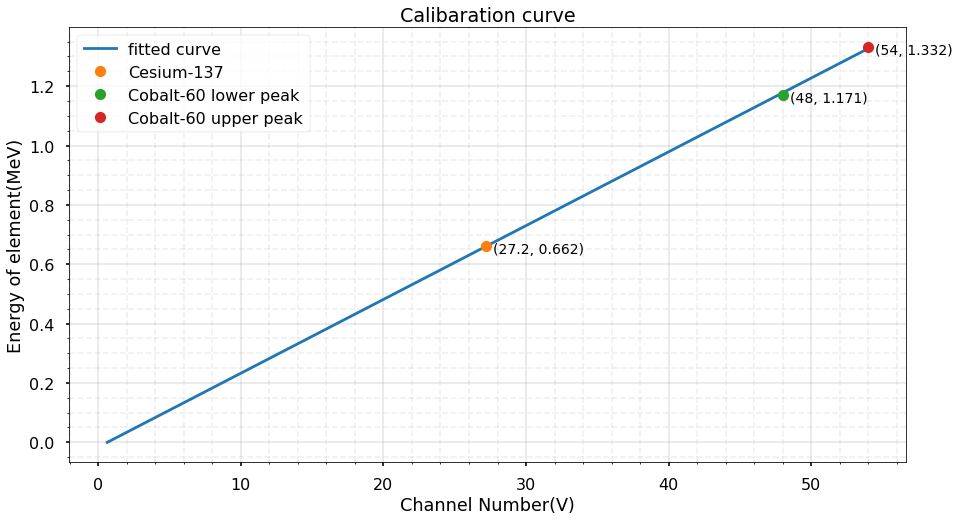

In [17]:
# extrapolated points
peak_channel_fit, known_energy_fit = polfit(peak_channel, known_energy, 1)
cal_chan_ext, cal_eng_ext = extrapolate1d(peak_channel_fit, known_energy_fit)

ckt = [item for item in cal_eng_ext if item >= 0]

plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))
plt.title(f"Calibaration curve")
plt.xlabel("Channel Number(V)")
plt.ylabel("Energy of element(MeV)")

# plt.plot(peak_channel, known_energy)

plt.plot(cal_chan_ext[634:], ckt, "-", label="fitted curve")
for i in range(len(res_name)):
    plt.plot(peak_channel[i], known_energy[i], "o", label=res_name[i])
    plt.annotate(f"({peak_channel[i]}, {known_energy[i]:.3f})", xy=(peak_channel[i]+0.5,known_energy[i]-0.025), fontsize=14)
plt.legend(loc="upper left")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")
plt.show()

In [18]:
scatter_peaks = [8.26, 17.10]
cs_scatter_energy = np.interp(scatter_peaks, cal_chan_ext, cal_eng_ext)
print(f"\n Back-scattering peak: {cs_scatter_energy[0]:.3f} MeV\n Compton edge peak energy: {cs_scatter_energy[1]:.3f} MeV")


 Back-scattering peak: 0.190 MeV
 Compton edge peak energy: 0.409 MeV


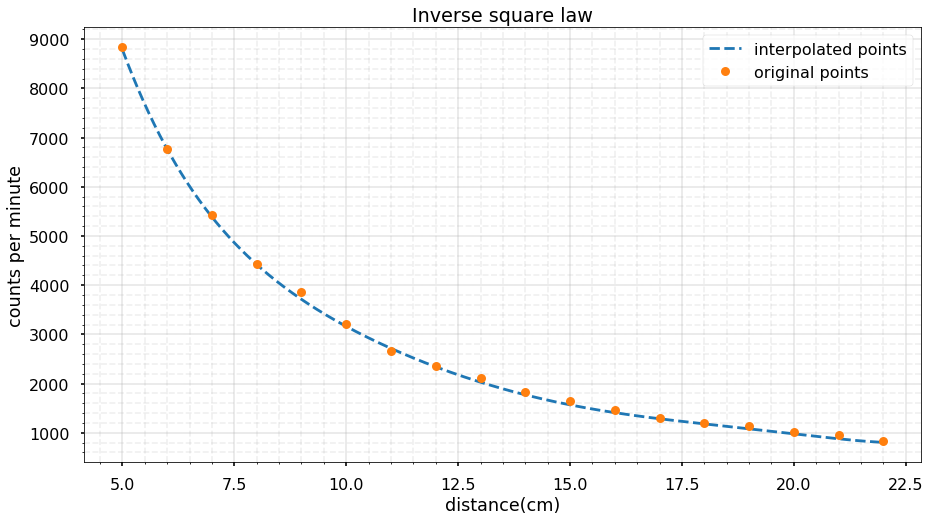

    distance  counts  net counts pm  counts ps  constant k
0          5    8843           8801  146.68333  3667.08333
1          6    6777           6735  112.25000  4041.00000
2          7    5426           5384   89.73333  4396.93333
3          8    4430           4388   73.13333  4680.53333
4          9    3870           3828   63.80000  5167.80000
5         10    3201           3159   52.65000  5265.00000
6         11    2656           2614   43.56667  5271.56667
7         12    2360           2318   38.63333  5563.20000
8         13    2110           2068   34.46667  5824.86667
9         14    1818           1776   29.60000  5801.60000
10        15    1638           1596   26.60000  5985.00000
11        16    1462           1420   23.66667  6058.66667
12        17    1299           1257   20.95000  6054.55000
13        18    1205           1163   19.38333  6280.20000
14        19    1129           1087   18.11667  6540.11667
15        20    1006            964   16.06667  6426.666

In [19]:
# converting counts per minute to per second
net_counts_ps = net_dist_counts_og/60
constant_k = net_counts_ps*distance_og*distance_og
data_dist["counts ps"] = net_counts_ps
data_dist["constant k"] = constant_k
dist_fitted, dist_counts_fitted = polfit(distance_og, net_dist_counts_og, 6)
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))

plt.title(f"Inverse square law")
plt.xlabel("distance(cm)")
plt.ylabel("counts per minute")
plt.plot(dist_fitted,dist_counts_fitted, "--", label="interpolated points")
plt.plot(distance_og,dist_counts_og, "o", markersize=9, label="original points")
plt.legend(loc="upper right")
plt.grid(alpha=0.3, which="major")
plt.minorticks_on()
plt.grid(alpha=0.2, which="minor", ls="--")

plt.show()
print(f"{data_dist}")